# Setting up dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install netCDF4
!pip install cartopy

!pip uninstall -y matplotlib
!pip install -U matplotlib==3.1.3

!pip uninstall -y shapely
!pip install shapely --no-binary shapely


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Found existing installation: matplotlib 3.1.3
Uninstalling matplotlib-3.1.3:
  Successfully uninstalled matplotlib-3.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.1.3-cp38-cp38-manylinux1_x86_64.whl (13.1 MB)


Found existing installation: Shapely 1.8.5.post1
Uninstalling Shapely-1.8.5.post1:
  Successfully uninstalled Shapely-1.8.5.post1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Shapely-1.8.5.post1.tar.gz (200 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.5.post1-cp38-cp38-linux_x86_64.whl size=755475 sha256=e0ceabedb45a86d7753266ada7b3602dbbc1939f14da51e42155c2ddf727f6c2
  Stored in directory: /root/.cache/pip/wheels/1e/b7/86/5badb596b4dcdcb8f0fa49a4b83e7d934681843c6dc406b16d
Successfully built shapely


In [3]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import glob

import matplotlib.pyplot as plt
from matplotlib.axes import Axes

import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh

from tabulate import tabulate
from pathlib import Path

data_path = 'drive/MyDrive/Stanford/CS230/Data/' 

!python --version

Python 3.8.15


# Exploring potential data augmentation

From the existing 16 channels, we aim to compute the following engineered features:

* **WS850**: wind speed at 850 hPa level
* **WSBOT**: wind speed at surface
* **RV850**: relative vorticity  at 850 hPa level
* **RVBOT**: relative vorticity at surface level

**Wind speed** is the L2 norm of the zonal + meridional components of the wind vector field:

$w_s = \sqrt{u^2 + v^2}$

**Wind vorticity** is the curl of the wind vector field around the w axis (λ = latitude, ϕ = longitude):

$\zeta = \frac{\partial u}{\partial λ} - \frac{1}{\textrm{cos} \phi} \frac{\partial v \textrm{cos} \theta}{\partial \phi}  $  




In [4]:
ds = xr.open_dataset(data_path+'ClimateNet/train/data-2004-08-19-01-1_0.nc') # loading one data sample

In [5]:
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2004-08-19-01-1.nc'
Data variables: (12/17)
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 ...
    V850     (time, lat, lon) float32 ...
    UBOT     (time, lat, lon) float32 ...
    VBOT     (time, lat, lon) float32 ...
    QREFHT   (time, lat, lon) float32 ...
    ...       ...
    TS       (time, lat, lon) float32 ...
    TREFHT   (time, lat, lon) float32 ...
    Z1000    (time, lat, lon) float32 ...
    Z200     (time, lat, lon) float32 ...
    ZBOT     (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...

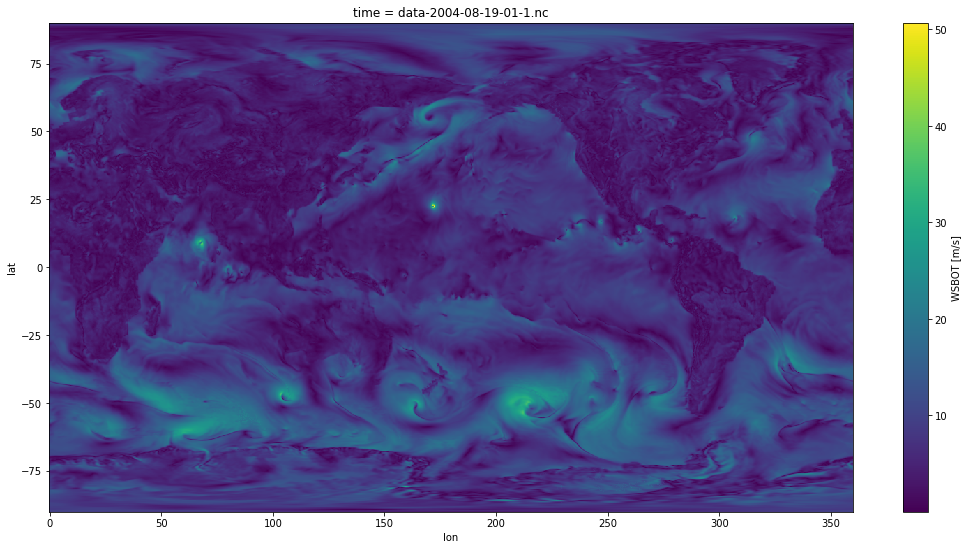

In [19]:
ubot = ds["UBOT"]
vbot = ds["VBOT"]
ds["WSBOT"] = np.sqrt(ubot**2 + vbot**2)
ds.WSBOT.attrs['description'] = 'wind speed at lowest level'
ds.WSBOT.attrs['units'] = 'm/s'

fig = plt.figure(figsize=(18,9))
ds.WSBOT[0,:,:].plot()

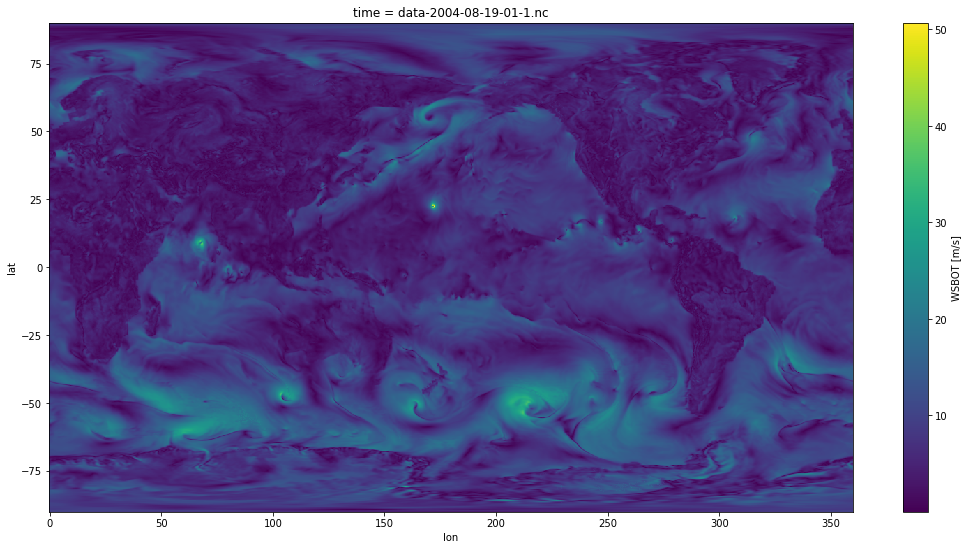

In [18]:
u850 = ds.U850
v850 = ds.U850
ds["WS850"] = np.sqrt(u850**2 + v850**2)
ds.WS850.attrs['description'] = 'wind speed at 850 hPa'
ds.WS850.attrs['units'] = 'm/s'

fig = plt.figure(figsize=(18,9))
ds.WSBOT[0,:,:].plot()

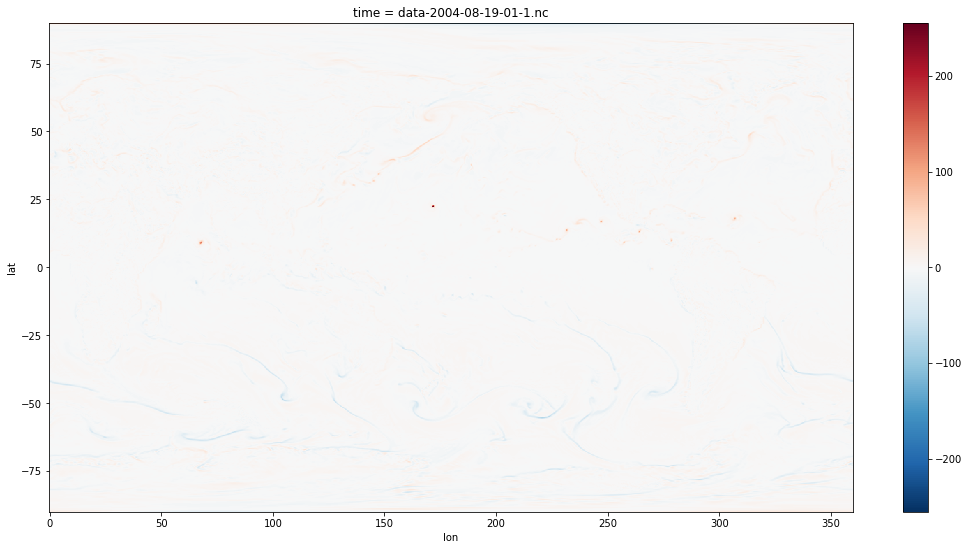

In [17]:
lat = ds["lat"]
lon = ds["lon"]
u = ds.UBOT[0,:,:]
v = ds.VBOT[0,:,:]

dv = v.differentiate("lon")

cosT = np.cos(lat*(np.pi/180))
u_cosT = u * cosT
du = (1/(1e-3+cosT)) * u_cosT.differentiate("lat")

vorticity_bottom = dv.astype(np.float32) - du.astype(np.float32)

ds["VORTBOT"] = vorticity_bottom
ds.VORTBOT.attrs['description'] = 'wind vorticity at lowest level'
ds.VORTBOT.attrs['units'] = 's^-1'

fig = plt.figure(figsize=(18,9))
p = vorticity_bottom.plot()

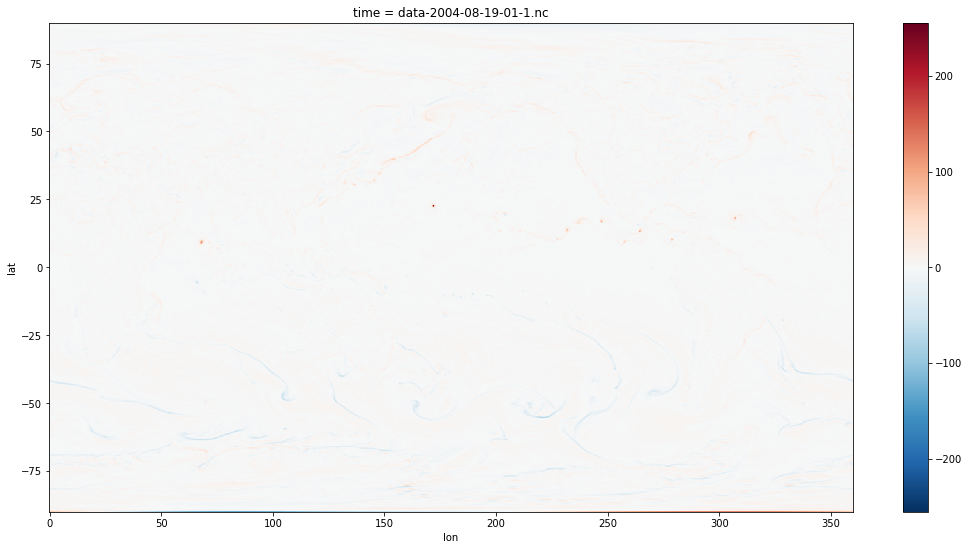

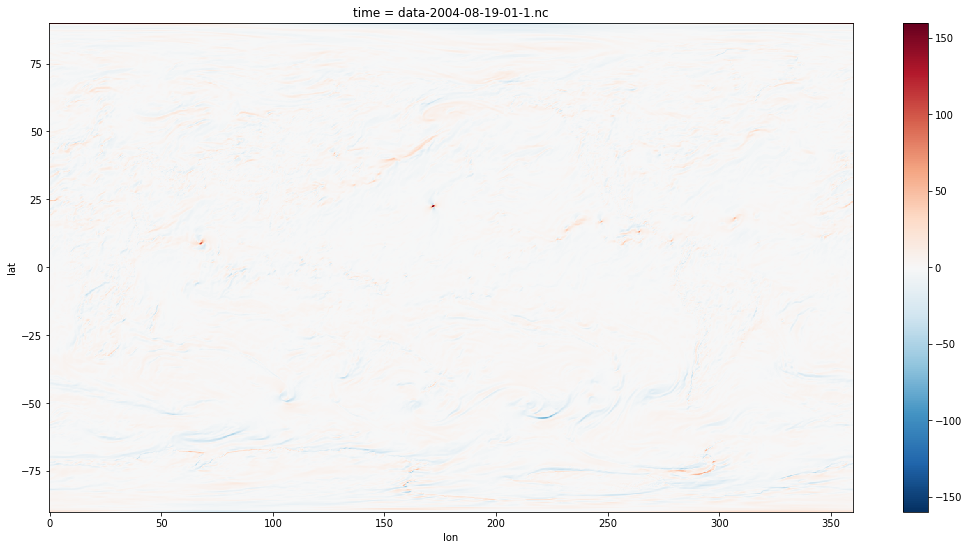

In [20]:
lat = ds["lat"]
lon = ds["lon"]
u = u850[0,:,:]
v = v850[0,:,:]

dv = v.differentiate("lon")

cosT = np.cos(lat*(np.pi/180))
u_cosT = u * cosT
du = (1/(1e-3+cosT)) * u_cosT.differentiate("lat")

vorticity850 = dv - du

ds["VORT850"] = vorticity850.astype(np.float32)
ds.VORT850.attrs['description'] = 'wind vorticity at 850 hPa'
ds.VORT850.attrs['units'] = 's^-1'

fig = plt.figure(figsize=(18,9))
p = vorticity850.plot()




# Generate new channels

We iterate through the train and test sets.

From the existing 16 channels, we aim to compute the following engineered features:

* WS850: wind speed at 850 hPa level
* WSBOT: wind speed at surface
* RV850: relative vorticity at 850 hPa level
* RVBOT: relative vorticity at surface level

We then keep only the following initial channels:
* U/VBOT
* U/V850
* PS
* TMQ
* PRECT

We then save the new sample to our Engineered data set.


In [ ]:
def velocity(u, v):

    wind_speed = np.sqrt(u**2 + v**2)
    return wind_speed


def vorticity(u, v):

    dv = v.differentiate("lon")
    cosTheta = np.cos(lat*(np.pi/180))
    
    u_cosTheta = u * cosTheta
    du = (1/(1e-3+cosTheta)) * u_cosTheta.differentiate("lat")

    zeta = dv - du
    return zeta.astype(np.float32)


In [ ]:
origin_folder = 'ClimateNet/train/' 
dest_folder = 'ClimateNet_Engineered/train/'

for idx, filename_in in enumerate(glob.glob(data_path + origin_folder + '*.nc')):

    ds = xr.open_dataset(filename_in)

    file = Path(filename_in)
    print(str(idx)+". Processing: "+file.stem+file.suffix)

    lat = ds["lat"]
    lon = ds["lon"]

    # Wind speed at 850 hPa
    ds["WS850"] = velocity(ds.U850, ds.V850)
    ds.WS850.attrs['description'] = 'wind speed at 850 mbar pressure surface'
    ds.WS850.attrs['units'] = 'm/s'

    # Wind speed at lower level
    ds["WSBOT"] = velocity(ds.UBOT, ds.VBOT)
    ds.WSBOT.attrs['description'] = 'lowest level wind speed'
    ds.WSBOT.attrs['units'] = 'm/s'

    # Wind vorticity at 850 hPa
    ds["VRT850"] = vorticity(ds.U850[0,:,:], ds.V850[0,:,:]).astype(np.float32)
    ds.VRT850.attrs['description'] = 'wind vorticity at 850 mbar pressure surface'
    ds.VRT850.attrs['units'] = 's^-1'

    # Wind vorticity at 850 hPa
    ds["VRTBOT"] = vorticity(ds.UBOT[0,:,:], ds.VBOT[0,:,:]).astype(np.float32)
    ds.VRTBOT.attrs['description'] = 'lowest level wind vorticity'
    ds.VRTBOT.attrs['units'] = 's^-1'
  
    # Clean up sample
    ds = ds.drop_vars(['TREFHT', 'PS', 'QREFHT', 'T200', 'T500', 'TS', 'TREFHT', 'Z1000', 'Z200', 'ZBOT'])
  
    # Save sample to new folder
    filename_out = data_path + dest_folder + file.stem + file.suffix
    print("Saving: "+filename_out+'\n')

    ds.to_netcdf(filename_out)
    

In [ ]:
ds

<xarray.Dataset>
Dimensions:  (lat: 768, lon: 1152, time: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.77 -89.53 -89.3 ... 89.3 89.53 89.77 90.0
  * lon      (lon) float64 0.0 0.3125 0.625 0.9375 ... 358.8 359.1 359.4 359.7
  * time     (time) object 'data-2013-09-27-01-1.nc'
Data variables:
    TMQ      (time, lat, lon) float32 ...
    U850     (time, lat, lon) float32 -5.058 -5.041 -5.025 ... -7.748 -7.759
    V850     (time, lat, lon) float32 -3.002 -3.029 -3.057 ... -2.051 -2.008
    UBOT     (time, lat, lon) float32 -5.058 -5.041 -5.025 ... -8.001 -8.028
    VBOT     (time, lat, lon) float32 -3.002 -3.029 -3.057 ... -4.989 -4.946
    PSL      (time, lat, lon) float32 ...
    PRECT    (time, lat, lon) float32 ...
    LABELS   (lat, lon) int64 ...
    WS850    (time, lat, lon) float32 5.881 5.881 5.881 ... 8.014 8.014 8.014
    WSBOT    (time, lat, lon) float32 5.881 5.881 5.881 ... 9.429 9.429 9.429
    VRT850   (lat, lon) float32 103.1 102.6 102.0 101.5 ... -160.3 -160.5 -160.8
    VRTBOT   (lat, lon) float32 103.1 102.6 102.0 101.5 ... -149.6 -150.1 -150.6

# Computing statistics 

Training our model requires a normalizing step that we pre-process to improve training speed. Here we compute `mean` and `std` for all channels.  

In [24]:
from math import pi
import pandas as pd

folder = 'ClimateNet_Engineered/train/' 
channels = ["TMQ", "U850", "V850", "UBOT", "VBOT", "PSL", "PRECT", "WS850", "WSBOT", "VRT850", "VRTBOT"]
pixels = ["LABELS:BG", "LABELS:TC", "LABELS:AR"]

col_names = []
for channel in channels:
  col_names += [channel+" Mean", channel+" Std Dev"]
col_names += pixels

df = pd.DataFrame(columns = col_names)

In [25]:
for idx, filename in enumerate(glob.glob(data_path + folder + '*.nc')):

    ds = xr.open_dataset(filename)

    file = Path(filename)
    if idx%10 == 0:
      print(str(idx)+". Processing: "+file.stem+file.suffix)

    new_row = []

    for channel in channels:
      new_row = new_row + [ds[channel].mean().values.item(),\
                          ds[channel].std().values.item()]

    labels = ds.LABELS
    counts = [labels.where(labels==0).count().values.item(),\
              labels.where(labels==1).count().values.item(),\
              labels.where(labels==2).count().values.item()]
    new_row = new_row + counts

    df = df.append(pd.Series(new_row, index=df.columns, name=str(idx)))

    ds.close()

df

0. Processing: data-1996-07-18-01-1_1.nc
10. Processing: data-1996-10-03-01-1_0.nc
20. Processing: data-1997-08-14-01-1_2.nc
30. Processing: data-1998-06-27-01-1_0.nc
40. Processing: data-1998-08-23-01-1_2.nc
50. Processing: data-1999-06-01-01-1_1.nc
60. Processing: data-1999-08-22-01-1_0.nc
70. Processing: data-2000-04-16-01-1_0.nc
80. Processing: data-2000-06-18-01-1_3.nc
90. Processing: data-2000-09-06-01-1_0.nc
100. Processing: data-2000-09-06-01-1_10.nc
110. Processing: data-2000-11-06-01-1_2.nc
120. Processing: data-2000-11-30-01-1_4.nc
130. Processing: data-2001-02-17-01-1_0.nc
140. Processing: data-2001-03-05-01-1_3.nc
150. Processing: data-2001-06-30-01-1_0.nc
160. Processing: data-2001-07-18-01-1_0.nc
170. Processing: data-2001-08-01-01-1_0.nc
180. Processing: data-2001-09-19-01-1_2.nc
190. Processing: data-2001-10-29-01-1_1.nc
200. Processing: data-2001-12-07-01-1_6.nc
210. Processing: data-2002-02-04-01-1_1.nc
220. Processing: data-2002-04-25-01-1_0.nc
230. Processing: data

,TMQ Mean,TMQ Std Dev,U850 Mean,U850 Std Dev,V850 Mean,V850 Std Dev,UBOT Mean,UBOT Std Dev,VBOT Mean,VBOT Std Dev,...,WS850 Std Dev,WSBOT Mean,WSBOT Std Dev,VRT850 Mean,VRT850 Std Dev,VRTBOT Mean,VRTBOT Std Dev,LABELS:BG,LABELS:TC,LABELS:AR
0,20.580984,15.302080,1.730609,8.190314,0.512662,5.783749,0.388602,6.638509,0.638699,5.603528,...,5.737500,7.415549,4.586711,0.018059,7.296667,0.009365,6.399208,836467.0,5604.0,42665.0
1,20.580984,15.302080,1.730609,8.190314,0.512662,5.783749,0.388602,6.638509,0.638699,5.603528,...,5.737500,7.415549,4.586711,0.018059,7.296667,0.009365,6.399208,828378.0,3947.0,52411.0
2,19.688189,15.440740,1.711115,7.922103,0.311553,6.484488,0.357344,6.452676,0.505371,5.992322,...,6.014335,7.369500,4.859888,0.081385,5.536661,0.065488,4.599821,859458.0,0.0,25278.0
3,19.688189,15.440740,1.711115,7.922103,0.311553,6.484488,0.357344,6.452676,0.505371,5.992322,...,6.014335,7.369500,4.859888,0.081385,5.536661,0.065488,4.599821,840360.0,15841.0,28535.0
4,20.538977,15.052717,1.681314,8.091788,0.449857,6.204360,0.325080,6.494568,0.610931,5.804701,...,5.769222,7.422890,4.610161,0.014086,6.026787,0.044658,5.474791,800105.0,5307.0,79324.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,18.224966,15.783622,2.235810,8.325841,0.060747,5.604892,0.402271,6.680420,0.070226,5.402025,...,5.718163,7.379867,4.417492,0.040603,5.898298,0.024230,6.309087,794044.0,7150.0,83542.0
394,18.224966,15.783622,2.235810,8.325841,0.060747,5.604892,0.402271,6.680420,0.070226,5.402025,...,5.718163,7.379867,4.417492,0.040603,5.898298,0.024230,6.309087,851198.0,7613.0,25925.0
395,17.845610,15.817519,1.950273,8.141109,0.022841,5.952164,0.323899,6.451836,0.208830,5.537879,...,5.571255,7.265780,4.432973,-0.047227,6.624439,-0.070357,5.795958,853083.0,5165.0,26488.0
396,17.845610,15.817519,1.950273,8.141109,0.022841,5.952164,0.323899,6.451836,0.208830,5.537879,...,5.571255,7.265780,4.432973,-0.047227,6.624439,-0.070357,5.795958,826672.0,3399.0,54665.0


Compute summary statistics:

In [78]:
from tabulate import tabulate

values = list(df.mean())

means = values[0:21:2]
stds = values[1:22:2]

table=list(zip(channels, means, stds))
print(tabulate(table, headers=['Channels', 'Mean', 'Std Dev'], tablefmt="presto"))

 Channels   |             Mean |        Std Dev
------------+------------------+----------------
 TMQ        |     19.2185      |   15.7346
 U850       |      1.55302     |    8.28026
 V850       |      0.254132    |    6.21792
 UBOT       |      0.124879    |    6.64294
 VBOT       |      0.315416    |    5.77158
 PSL        | 100814           | 1443.81
 PRECT      |      2.94582e-08 |    1.55088e-07
 WS850      |      8.70061     |    5.85448
 WSBOT      |      7.47795     |    4.672
 VRT850     |      0.00256632  |    6.85154
 VRTBOT     |     -0.00130753  |    6.11551


Channels   |             Mean |        Std Dev
------------|------------------|----------------
 TMQ        |     19.2185      |   15.7346
 U850       |      1.55302     |    8.28026
 V850       |      0.254132    |    6.21792
 UBOT       |      0.124879    |    6.64294
 VBOT       |      0.315416    |    5.77158
 PSL        | 100814           | 1443.81
 PRECT      |      2.94582e-08 |    1.55088e-07
 WS850      |      8.70061     |    5.85448
 WSBOT      |      7.47795     |    4.672
 VRT850     |      0.00256632  |    6.85154
 VRTBOT     |     -0.00130753  |    6.11551